# HDA Project Speech Recognition

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, backend, initializers, mixed_precision
from tensorflow.keras.utils import audio_dataset_from_directory
import matplotlib.pyplot as plt
from numba import cuda

In [2]:
policy = mixed_precision.Policy('float32')
mixed_precision.set_global_policy(policy)
tf.config.experimental.set_virtual_device_configuration(tf.config.experimental.list_physical_devices('GPU')[0],
[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6144)])

#### Loading and Preprocessing the Data

In [3]:
df_train, df_val = audio_dataset_from_directory(directory='D:\HDA\data', 
                                                labels='inferred', 
                                                label_mode='int', 
                                                batch_size=32, 
                                                validation_split=0.2, 
                                                subset='both', 
                                                seed=0)
labels = np.array(df_train.class_names)

Found 105835 files belonging to 36 classes.
Using 84668 files for training.
Using 21167 files for validation.


In [4]:
def squeeze_samples(audio, label):
    audio = tf.squeeze(audio, axis=-1)
    return audio, label

df_train = df_train.map(squeeze_samples, tf.data.AUTOTUNE)
df_val = df_val.map(squeeze_samples, tf.data.AUTOTUNE)

def get_spectrogram(waveform, frame_length=550, frame_step=128, mel=True):
    
    spectrogram = tf.signal.stft(waveform, frame_length=frame_length, frame_step=frame_step)
    spectrogram = tf.abs(spectrogram)
    num_spectrogram_bins = spectrogram.shape[-1]
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 0.0, 3000.0, 120
    mel_matrix = tf.signal.linear_to_mel_weight_matrix(num_mel_bins=num_mel_bins, 
                                                       num_spectrogram_bins=num_spectrogram_bins, 
                                                       sample_rate=16000, 
                                                       lower_edge_hertz=lower_edge_hertz, 
                                                       upper_edge_hertz=upper_edge_hertz)
    mel_spectrogram = tf.tensordot(spectrogram, mel_matrix, 1)
    mel_spectrogram.set_shape(spectrogram.shape[:-1].concatenate(mel_matrix.shape[-1:]))
    mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)
    
    if mel:
        return mel_spectrogram[...,tf.newaxis]
    return np.log(spectrogram.numpy().T + np.finfo(float).eps)[..., tf.newaxis]

def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    height = spectrogram.shape[0]
    width = spectrogram.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, spectrogram)
    
def make_spec_ds(ds):
    return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

def squeeze_audio(x):
    x = tf.squeeze(x, axis=0)
    return x

In [5]:
df_test = df_val.shard(num_shards=2, index=0)
df_val = df_val.shard(num_shards=2, index=1)

for example_audio, example_label in df_train.take(1):
    break
    

waveform = example_audio[1]
spectrogram = get_spectrogram(example_audio[0], mel=False)
spectrogram1 = get_spectrogram(example_audio[0])

    
train_spectrogram_ds = make_spec_ds(df_train).cache()
val_spectrogram_ds = make_spec_ds(df_val).prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = make_spec_ds(df_test).prefetch(tf.data.AUTOTUNE)
    
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
    break

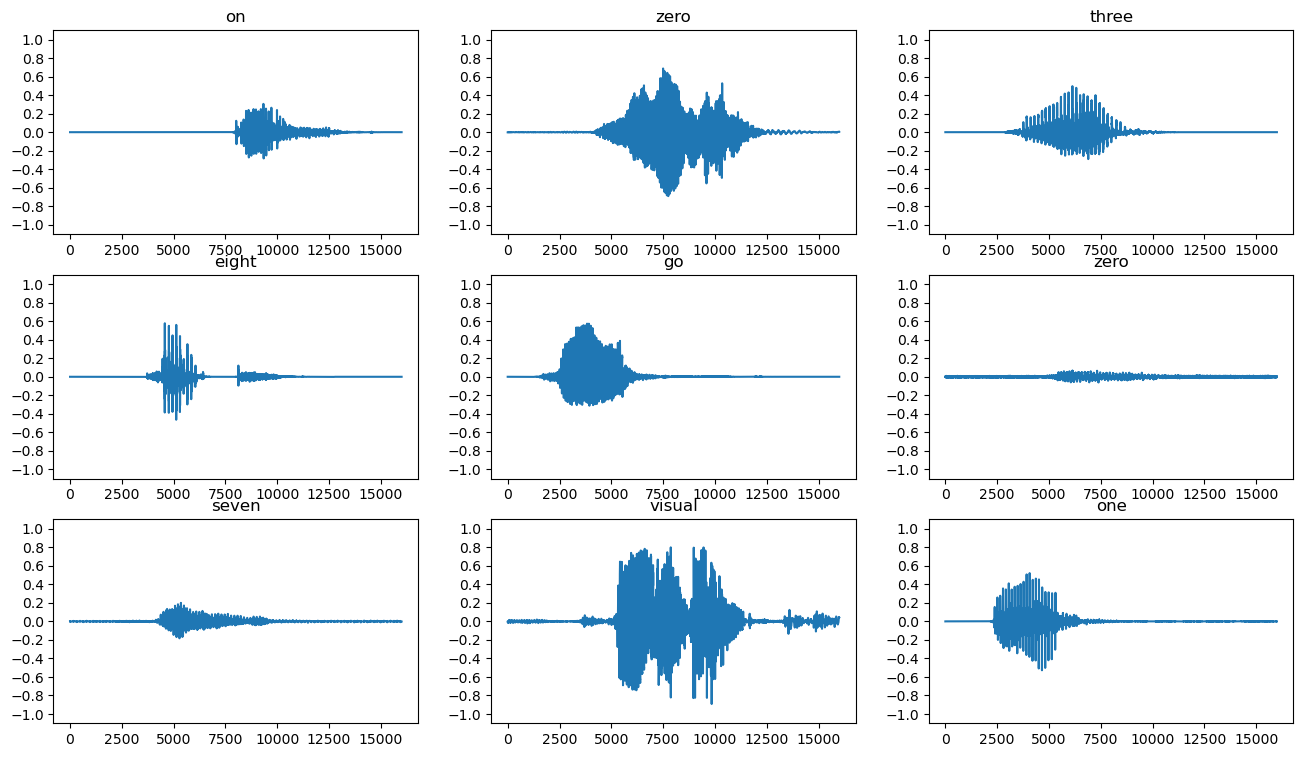

In [6]:
row = 3
cols = 3
n = row * cols
fig, axes = plt.subplots(row, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(example_audio[i].numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = labels[example_label[i]]
    ax.set_title(label)
    ax.set_ylim([-1.1,1.1])

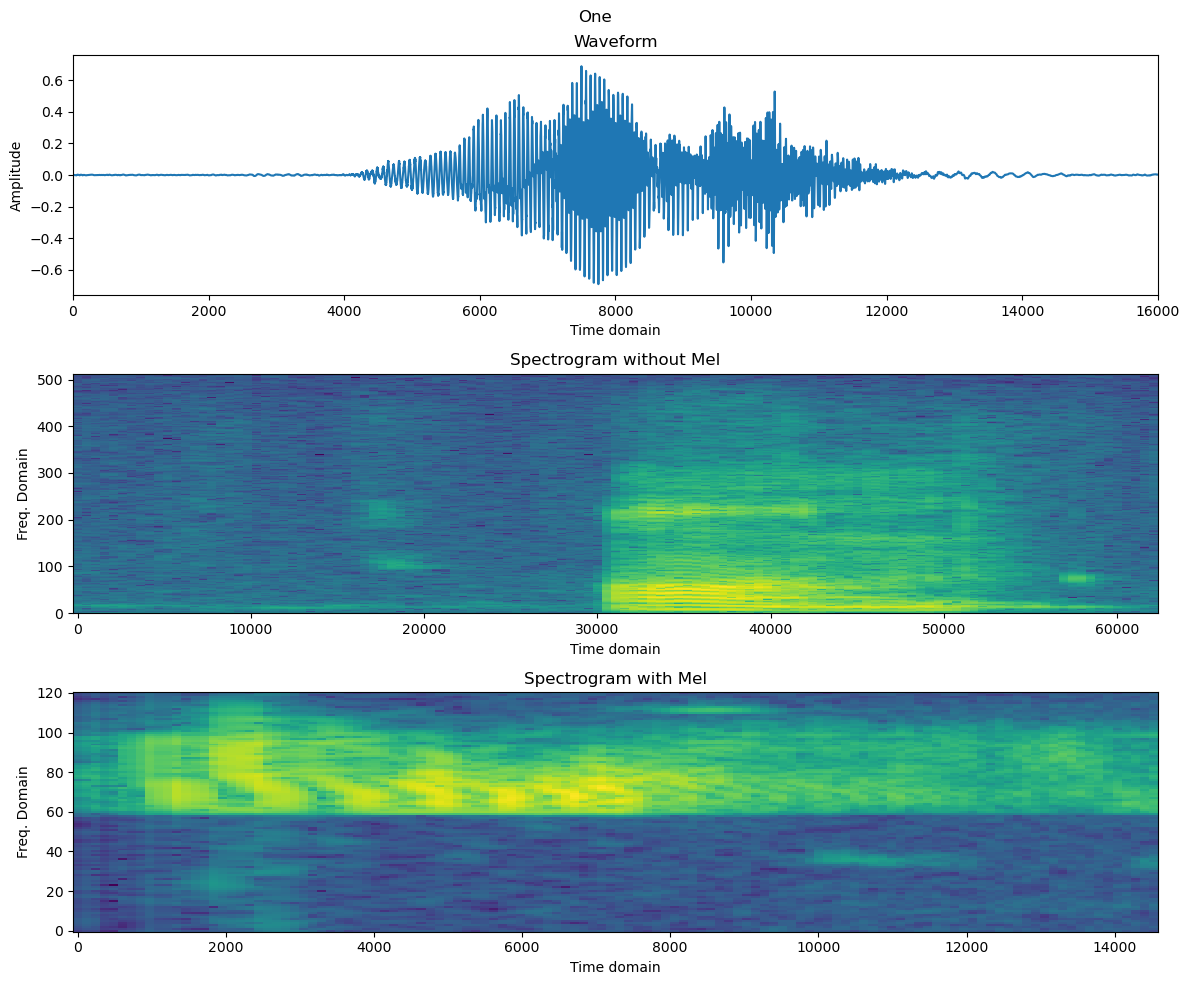

In [7]:
fig, axes = plt.subplots(3, figsize=(12, 10))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
axes[0].set_xlabel('Time domain')
axes[0].set_ylabel('Amplitude')
#axes[1].set_xlim([0, 16000])
axes[1].set_xlabel('Time domain')
axes[1].set_ylabel('Freq. Domain')
axes[2].set_xlabel('Time domain')
axes[2].set_ylabel('Freq. Domain')


plot_spectrogram(spectrogram, axes[1])
plot_spectrogram(spectrogram1, axes[2])
axes[1].set_title('Spectrogram without Mel')
axes[2].set_title('Spectrogram with Mel')
plt.suptitle(label.title())
fig.tight_layout()
plt.show()

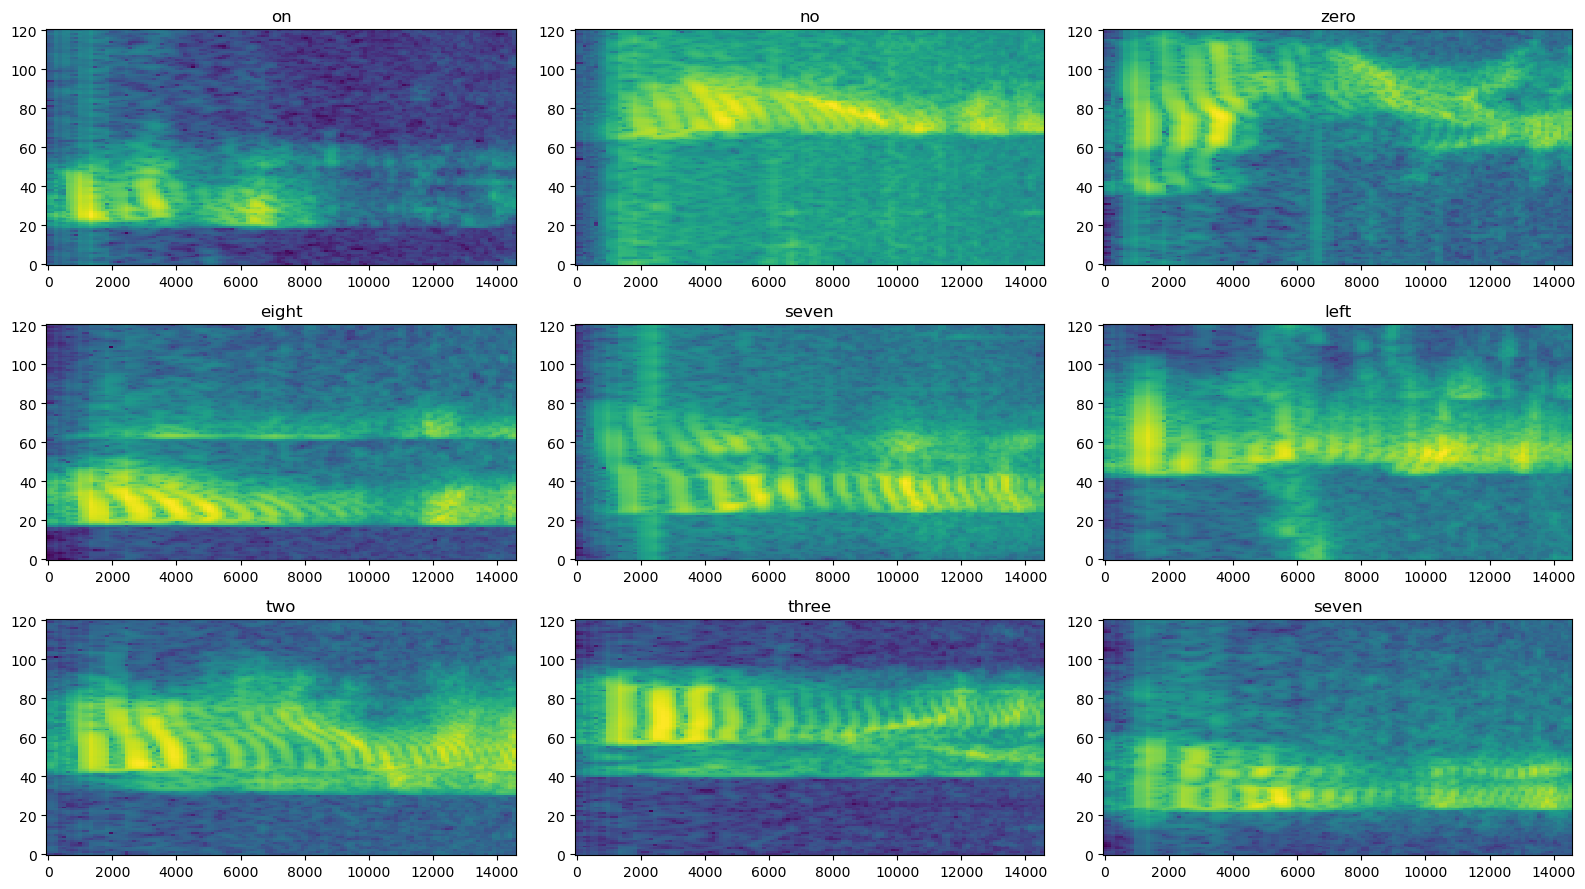

In [8]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

rows = 3
cols = 3
n = rows * cols

fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i], ax)
    ax.set_title(labels[example_spect_labels[i].numpy()])

fig.tight_layout()
plt.show()

In [9]:
for x, y in val_spectrogram_ds.take(1):
    print(x.shape)

(32, 121, 120, 1)


In [19]:
import test_models as m
import importlib
importlib.reload(m)


model = m.CNN_Bi_3convLSTM()

In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_4 (Resizing)       (None, 64, 64, 1)         0         
                                                                 
 normalization_4 (Normalizat  (None, 64, 64, 1)        3         
 ion)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 10)        820       
                                                                 
 batch_normalization_8 (Batc  (None, 64, 64, 10)       40        
 hNormalization)                                                 
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 32, 32, 10)       0         
 g2D)                                                            
                                                      

In [21]:
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + m.CNN_Bi_3convLSTM.__name__+ 'Pooling' + '_softmax'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1,  profile_batch = '500,520')

EPOCHS = 15
history = model.fit(
        train_spectrogram_ds,
        validation_data=val_spectrogram_ds,
        epochs=EPOCHS,
        callbacks=tensorboard_callback,
        workers=-1
        )


Epoch 1/15
2646/2646 [==============================] - 2005s 752ms/step - loss: 0.9586 - accuracy: 0.7149 - val_loss: 0.5368 - val_accuracy: 0.8361
Epoch 2/15
2646/2646 [==============================] - 1833s 693ms/step - loss: 0.4804 - accuracy: 0.8546 - val_loss: 0.4575 - val_accuracy: 0.8623
Epoch 3/15
2646/2646 [==============================] - 1830s 692ms/step - loss: 0.3943 - accuracy: 0.8805 - val_loss: 0.4106 - val_accuracy: 0.8755
Epoch 4/15
2646/2646 [==============================] - 1831s 692ms/step - loss: 0.3427 - accuracy: 0.8957 - val_loss: 0.3790 - val_accuracy: 0.8867
Epoch 5/15
2646/2646 [==============================] - 1830s 692ms/step - loss: 0.3039 - accuracy: 0.9074 - val_loss: 0.3799 - val_accuracy: 0.8900
Epoch 6/15
2646/2646 [==============================] - 1821s 688ms/step - loss: 0.2720 - accuracy: 0.9171 - val_loss: 0.3715 - val_accuracy: 0.8924
Epoch 7/15
2646/2646 [==============================] - 1828s 691ms/step - loss: 0.2470 - accuracy: 0.9239

In [22]:
model.save('D:\HDA\models\ ' + m.CNN_Bi_3convLSTM.__name__ + 'Pooling' +'_softmax')

INFO:tensorflow:Assets written to: D:\HDA\models\ CNN_Bi_3convLSTMPooling_softmax\assets


INFO:tensorflow:Assets written to: D:\HDA\models\ CNN_Bi_3convLSTMPooling_softmax\assets


In [106]:
speech_models = np.array([x for y, x in m.__dict__.items() if 'CNN' in y and callable(x) ])
speech_models

array([<function CNN_Bi_2convLSTM at 0x00000195AE77D820>,
       <function CNN_Bi_1convLSTM_1LSTM at 0x00000195AF076790>,
       <function CNN_2convLSTM at 0x0000019635CD5430>,
       <function CNN at 0x00000195F97F2F70>,
       <function residual_CNN_RNN at 0x00000195AF1F4790>,
       <function CNN_Bi_2convLSTM_AT at 0x000001959BD0EC10>], dtype=object)

In [111]:
for speech_model in speech_models:
    
    model = speech_model()
    EPOCHS = 15
    
    lr_fn = tf.keras.optimizers.schedules.PolynomialDecay(0.0017, EPOCHS, 0.00075)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr_fn),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
    )

    model.summary()
    
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + speech_model.__name__
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1,  profile_batch = '500,520')

    
    history = model.fit(
        train_spectrogram_ds,
        validation_data=val_spectrogram_ds,
        epochs=EPOCHS,
        callbacks=tensorboard_callback,
        workers=-1
        )
    
    model.save('D:\HDA\models\model_' + speech_model.__name__)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_10 (Resizing)      (None, 64, 64, 1)         0         
                                                                 
 normalization_39 (Normaliza  (None, 64, 64, 1)        3         
 tion)                                                           
                                                                 
 conv2d_76 (Conv2D)          (None, 64, 64, 10)        820       
                                                                 
 batch_normalization_76 (Bat  (None, 64, 64, 10)       40        
 chNormalization)                                                
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 32, 32, 10)       0         
 g2D)                                                            
                                                      

INFO:tensorflow:Assets written to: D:\HDA\models\model_CNN_Bi_2convLSTM\assets


INFO:tensorflow:Assets written to: D:\HDA\models\model_CNN_Bi_2convLSTM\assets


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_11 (Resizing)      (None, 64, 64, 1)         0         
                                                                 
 normalization_39 (Normaliza  (None, 64, 64, 1)        3         
 tion)                                                           
                                                                 
 conv2d_78 (Conv2D)          (None, 64, 64, 10)        60        
                                                                 
 batch_normalization_78 (Bat  (None, 64, 64, 10)       40        
 chNormalization)                                                
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 32, 32, 10)       0         
 g2D)                                                            
                                                      

INFO:tensorflow:Assets written to: D:\HDA\models\model_CNN_Bi_1convLSTM_1LSTM\assets


INFO:tensorflow:Assets written to: D:\HDA\models\model_CNN_Bi_1convLSTM_1LSTM\assets


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_12 (Resizing)      (None, 64, 64, 1)         0         
                                                                 
 normalization_39 (Normaliza  (None, 64, 64, 1)        3         
 tion)                                                           
                                                                 
 conv2d_80 (Conv2D)          (None, 64, 64, 10)        60        
                                                                 
 batch_normalization_81 (Bat  (None, 64, 64, 10)       40        
 chNormalization)                                                
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 32, 32, 10)       0         
 g2D)                                                            
                                                      

INFO:tensorflow:Assets written to: D:\HDA\models\model_CNN_2convLSTM\assets


INFO:tensorflow:Assets written to: D:\HDA\models\model_CNN_2convLSTM\assets


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_13 (Resizing)      (None, 64, 64, 1)         0         
                                                                 
 normalization_39 (Normaliza  (None, 64, 64, 1)        3         
 tion)                                                           
                                                                 
 conv2d_82 (Conv2D)          (None, 64, 64, 32)        131104    
                                                                 
 batch_normalization_85 (Bat  (None, 64, 64, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                      

INFO:tensorflow:Assets written to: D:\HDA\models\model_CNN\assets


INFO:tensorflow:Assets written to: D:\HDA\models\model_CNN\assets


Model: "Residual_CNN_RNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_47 (InputLayer)          [(None, 121, 120, 1  0           []                               
                                )]                                                                
                                                                                                  
 resizing_14 (Resizing)         (None, 64, 64, 1)    0           ['input_47[0][0]']               
                                                                                                  
 average_pooling2d (AveragePool  (None, 64, 64, 1)   0           ['resizing_14[0][0]']            
 ing2D)                                                                                           
                                                                                   

INFO:tensorflow:Assets written to: D:\HDA\models\model_residual_CNN_RNN\assets


INFO:tensorflow:Assets written to: D:\HDA\models\model_residual_CNN_RNN\assets


(None, 59)
Model: "Residual_CNN_RNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_48 (InputLayer)          [(None, 121, 120, 1  0           []                               
                                )]                                                                
                                                                                                  
 resizing_15 (Resizing)         (None, 64, 64, 1)    0           ['input_48[0][0]']               
                                                                                                  
 normalization_39 (Normalizatio  (None, 64, 64, 1)   3           ['resizing_15[0][0]']            
 n)                                                                                               
                                                                        

D:\anaconda3\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1323/1323 [==============================] - 2733s 2s/step - loss: 2.6469 - accuracy: 0.2189 - val_loss: 2.2429 - val_accuracy: 0.3112
Epoch 2/15
1323/1323 [==============================] - 2597s 2s/step - loss: 1.9779 - accuracy: 0.4044 - val_loss: 1.7051 - val_accuracy: 0.4895
Epoch 3/15
1323/1323 [==============================] - 2583s 2s/step - loss: 1.4997 - accuracy: 0.5496 - val_loss: 1.3962 - val_accuracy: 0.5919
Epoch 4/15
1323/1323 [==============================] - 2585s 2s/step - loss: 1.2744 - accuracy: 0.6178 - val_loss: 1.2197 - val_accuracy: 0.6439
Epoch 5/15
1323/1323 [==============================] - 2581s 2s/step - loss: 1.1333 - accuracy: 0.6613 - val_loss: 1.1114 - val_accuracy: 0.6689
Epoch 6/15
1323/1323 [==============================] - 2593s 2s/step - loss: 1.0309 - accuracy: 0.6922 - val_loss: 1.0388 - val_accuracy: 0.6969
Epoch 7/15
1323/1323 [==============================] - 2592s 2s/step - loss: 0.9564 - accuracy: 0.7127 - val_loss: 0.9523 - val_accura

INFO:tensorflow:Assets written to: D:\HDA\models\model_CNN_Bi_2convLSTM_AT\assets


INFO:tensorflow:Assets written to: D:\HDA\models\model_CNN_Bi_2convLSTM_AT\assets


Text(0, 0.5, 'Accuracy [%]')

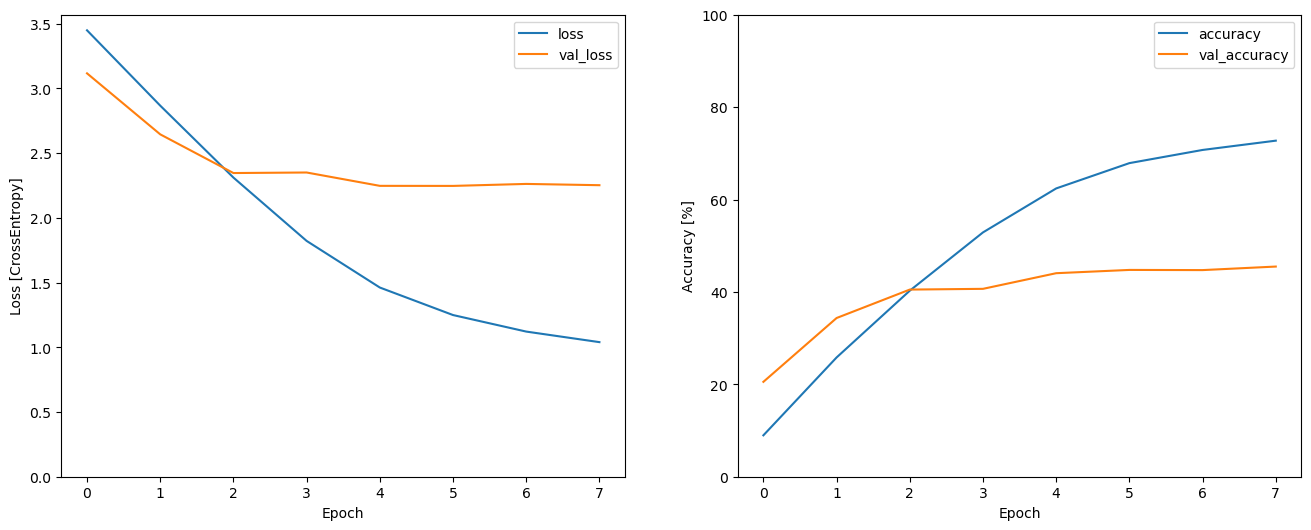

In [29]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')